<a href="https://colab.research.google.com/github/ramon-m-machado/Markdown-Tutorial/blob/master/VGGs_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of microorganisms into 10 classes using **VGG16** and **VGG19**


# Environment Setup

## GPU

In [44]:
# checking the use of colab's GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Drive


In [45]:
# get the images from the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [46]:
# basic imports
import numpy as np
import pandas as pd

In [47]:
# plot imports
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.graph_objects as go

In [48]:
# read and process images
import imageio.v2 as iio
from PIL import Image
import cv2 as cv

In [49]:
# access files in colab's folders
import os

In [50]:
# regex to get the class name from the file name
import re

In [51]:
# k-fold (cross validation)
from sklearn.model_selection import StratifiedKFold
# like top_k_categorical_accuracy but for labels integer-encoded
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy

In [52]:
# imports data augmentation
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img

In [53]:
# confusion matrix
from plotly.subplots import make_subplots
from matplotlib.colors import LinearSegmentedColormap

In [54]:
# imports from evaluation metrics
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score

## Control constants

Path info

In [55]:
# define values related to Colab's environment path
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/FAPESP/images/'
# BASE_PATH = '/content/drive/MyDrive/micro_data/'
FOLDERS = ['Control/', 'Serial/', 'Streak/']  # images will be read from these 3 folders in the base path

Learning info

In [56]:
# define values related to learning, such as image size and number of classes
SIZE = 224  # (size, size)
BORDER = 150  # this will be cutted from the original image, because the microorganism are in the center

NUMBER_OF_CLASSES = 10

BATCH_SIZE = 32

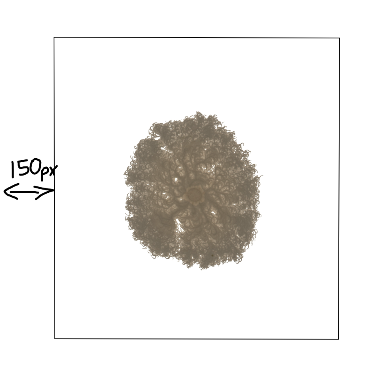

# Loading and preprocessing images

## Read images and construct Dataset

Defining functions to read and preprocess images

In [57]:
def preprocessImg(path, size, border):
  # read the images in folder
  img = np.array(Image.open(path)) #.convert('L')) # uncoment to gray scale images

  # standardizating values (interval [0, 1])
  imgStandard = img / 255

  # cut the border of the image
  imgCutted = imgStandard[border:-border,border:-border]

  # resize the original image
  imgResized = cv.resize(imgCutted, dsize = (size, size))

  return imgResized

In [58]:
def getClassWithRegex(file):
  regex_result = re.search(r"\d-\d*_.M_P1C(\d+)", file)
  imgClass = int(regex_result.groups()[0])-1

  y = np.zeros(NUMBER_OF_CLASSES)
  y[imgClass] = 1

  return y

In [59]:
def readDataImagesFromDrive(size, border, batch_size):
  for i in range(len(FOLDERS)):
    for file in os.listdir(BASE_PATH + FOLDERS[i]):
      img = preprocessImg(BASE_PATH + FOLDERS[i] + file, size, border)
      imgClass = getClassWithRegex(file)

      yield img, imgClass

In [60]:
# constructing the image dataset
dataset = tf.data.Dataset.from_generator(
    lambda : readDataImagesFromDrive(SIZE, BORDER, BATCH_SIZE),
    output_signature=(
         tf.TensorSpec(shape=(SIZE, SIZE, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(NUMBER_OF_CLASSES), dtype=tf.int8)
    )
).batch(BATCH_SIZE)

Images examples

In [61]:
# creating a data iterator to access the actual data
iterator = dataset.as_numpy_iterator()

In [62]:
# getting the first batch of data
batch = iterator.next()

images = batch[0]
labels = batch[1]

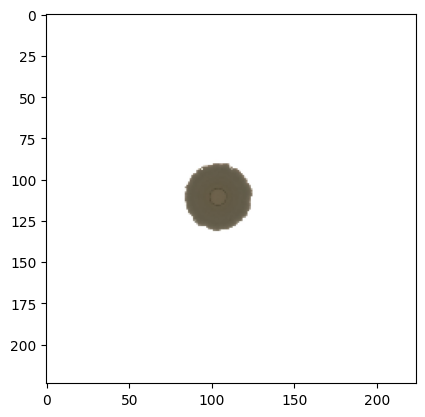

In [63]:
plt.imshow(images[0])

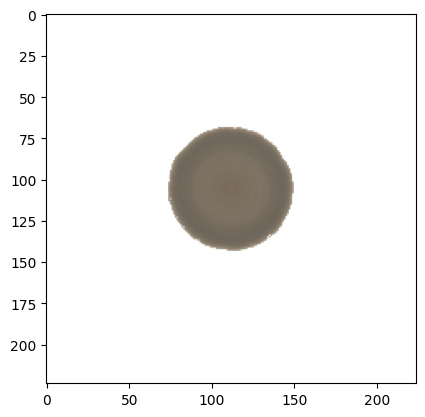

In [64]:
plt.imshow(images[15])

# Training

## Data Augmentation

modify the input images to improve the model generalization

In [65]:
input_shape = (SIZE, SIZE, 3)

In [66]:
dataAugmentation = tf.keras.models.Sequential([
  tf.keras.layers.RandomRotation(factor=0.05,fill_mode='nearest', input_shape = input_shape),
  tf.keras.layers.RandomZoom(0.05)]
)

## Model

In [ ]:
# constructing the CNN model
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

cnn = tf.keras.models.Sequential()

cnn.add(dataAugmentation)

cnn.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(SIZE, SIZE, 3)))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Conv2D(16, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())

cnn.add(Flatten())

cnn.add(Dense(256, activation='sigmoid'))
cnn.add(Dense(NUMBER_OF_CLASSES, activation='softmax'))

In [ ]:
# compiling/building the CNN model
cnn.compile('adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
cnn.build((None, SIZE, SIZE, 3))
cnn.summary()

In [ ]:
train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.66, shuffle=True)

cnn.fit(
  train_dataset,
  epochs = 20
)

cnn.evaluate(test_dataset)

## VGG16

In [71]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import optimizers
from keras.layers import Dense, Flatten

In [72]:
vgg = VGG16(input_shape = input_shape, weights='imagenet', include_top=False)

#don't train existing weights
for layer in vgg.layers:
 layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras.callbacks import ReduceLROnPlateau

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
# checkpoint = ModelCheckpoint(filepath='mymodel.h5',
#                                verbose=1, save_best_only=True)
# callbacks = [checkpoint, lr_reducer]

In [74]:
train_dataset, test_dataset = tf.keras.utils.split_dataset(dataset, left_size=0.66, shuffle=True)

In [77]:
history = model.fit_generator(train_dataset,
                    epochs = 18, verbose=5,
                    validation_data = test_dataset)

Epoch 1/18


<ipython-input-77-dc89dd25cd56>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_dataset,


Epoch 2/18
Epoch 3/18
Epoch 4/18
Epoch 5/18
Epoch 6/18
Epoch 7/18
Epoch 8/18
Epoch 9/18
Epoch 10/18
Epoch 11/18
Epoch 12/18
Epoch 13/18
Epoch 14/18
Epoch 15/18
Epoch 16/18
Epoch 17/18
Epoch 18/18


In [78]:
score = model.evaluate(test_dataset)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 75ms/step - loss: 0.7296 - accuracy: 0.7647
Test Loss: 0.7295967936515808
Test accuracy: 0.7647058963775635
